In [44]:
import numpy as np
import pandas as pd
from os import path
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

n_bins_default = 15

In [45]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        df = cache_dict['df']
        p = list(cache_dict['parameter_names'])
        return df, p

In [46]:
class ModelPlot:
    def __init__(self, x, y, d, label, color, linewidth=3):
        self.label = label
        self.color = color
        self.linewidth = linewidth
        self.x = x
        self.y = y
        self.d = d

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def plot_model(model_plot_list, n_bins, ax=None, percentiles=False):
    p = ax if ax is not None else plt
    for model_plot in model_plot_list:
        d_grouped_by_gs = model_plot.d.groupby(pd.cut(model_plot.d[model_plot.x.name], n_bins))
        d_grouped_by_gs_agg = d_grouped_by_gs.agg([np.mean, percentile(10), percentile(90)])
        
        p.plot(
            d_grouped_by_gs_agg[model_plot.x.name]['mean'],
            d_grouped_by_gs_agg[model_plot.y.name]['mean'],
            label=model_plot.label,
            color=model_plot.color,
            linewidth=model_plot.linewidth,
        )
        if percentiles:
            p.errorbar(
                d_grouped_by_gs_agg[model_plot.x.name]['mean'],
                d_grouped_by_gs_agg[model_plot.y.name]['mean'],
                yerr=[
                    d_grouped_by_gs_agg[model_plot.y.name]['percentile_10'],
                    d_grouped_by_gs_agg[model_plot.y.name]['percentile_90'],
                ], 
                color=model_plot.color,
            )
        
        if ax is not None:
            ax.set(xlabel=model_plot.x.name, ylabel=model_plot.y.name)
        else:
            plt.xlabel(model_plot.x.name)
            plt.ylabel(model_plot.y.name)

In [47]:
rename_dict = {
    'relative_localization_error_translation_mean': 'translation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs_sensor',
    'geometric_similarity_range_limit_mean_of_translation_eigenvalues_ratio_all': 'tgs_range',
    'geometric_similarity_mean_of_translation_eigenvalues_ratio_all': 'tgs_fixed',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr',
    'waypoint_start_time': 'start_time',
}
p = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'environment_name',
    'slam_node',
]
m = [
    'start_time',
    'translation_error',
    'tgs_sensor',
    'tgs_range',
    'tgs_fixed',
    'lvr',
]
df, params = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")

df.rename(columns=rename_dict, inplace=True)
df.columns
df = df[df.beta == (2.0, 0.0, 2.0, 0.0)][p+m]

for c in p:
    print("{:>30}".format(c), sorted(list(df[c].unique())))

          laser_scan_max_range [3.5, 8.0, 30.0]
            laser_scan_fov_deg [90, 180, 359]
              environment_name ['7A-2', 'airlab', 'fr079', 'office_b']
                     slam_node ['gmapping', 'slam_toolbox']


In [48]:
print(df.groupby(df.slam_node).translation_error.agg(["min", "mean", "max"]))

                   min      mean        max
slam_node                                  
gmapping      0.000001  0.859405  74.233677
slam_toolbox  0.000001  0.202956  17.057477


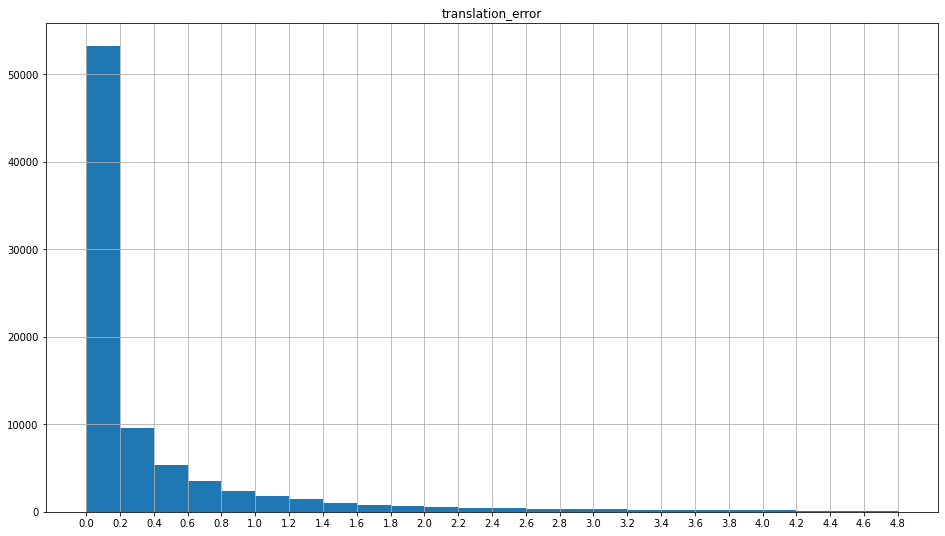

In [49]:
plt.hist(df.translation_error, bins=np.arange(0, 5, 0.2))
plt.xticks(np.arange(0, 5, 0.2))
plt.title("translation_error")
plt.grid(True)
plt.show()

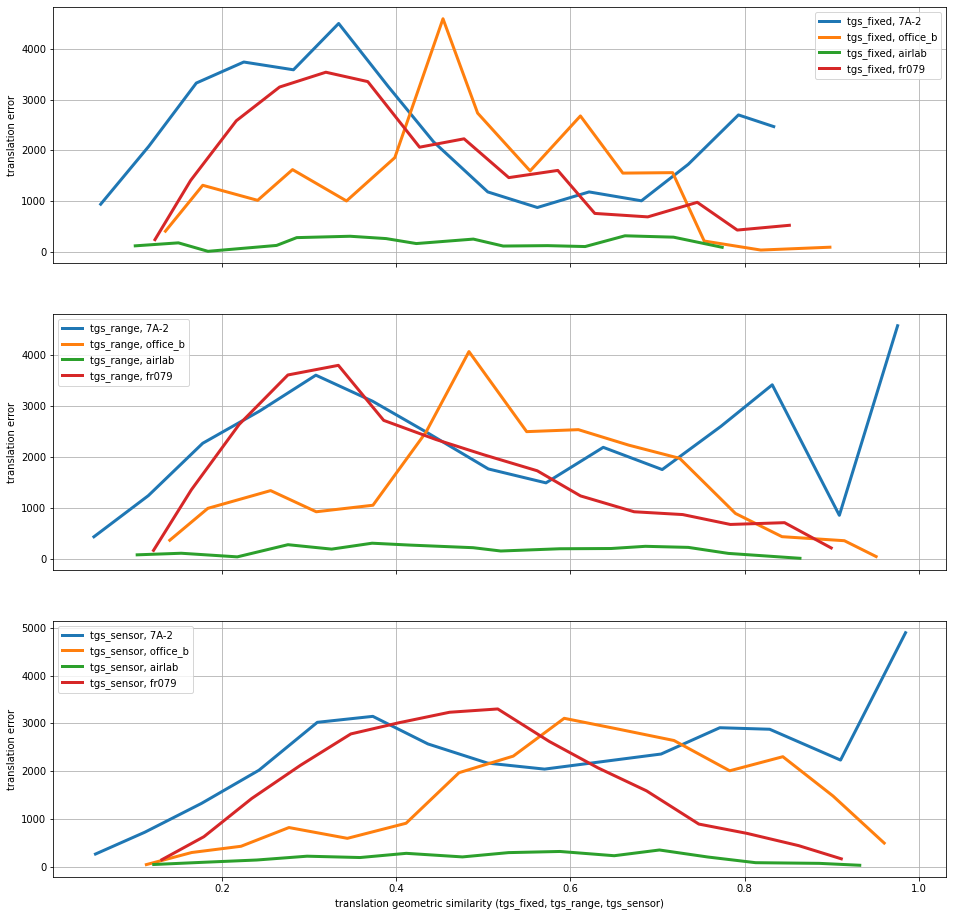

In [50]:
fig, axs = plt.subplots(3)
for ax in axs.flat:
    ax.set(
        xlabel='translation geometric similarity (tgs_fixed, tgs_range, tgs_sensor)', 
        ylabel='translation error')
for ax in axs.flat:
    ax.label_outer()

gs_metrics = ["tgs_fixed", "tgs_range", "tgs_sensor"]
for gs_metric, ax in zip(gs_metrics, axs):
    for env_name in df.environment_name.unique():
        df_by_env = df[df.environment_name == env_name]
        df_by_env_bined = df_by_env.groupby(pd.cut(df_by_env[gs_metric], n_bins_default))
        df_hist = df_by_env_bined.agg(['mean', 'count'])
        ax.plot(
            df_hist[(gs_metric, 'mean')], 
            df_hist[(gs_metric, 'count')], 
            label=f"{gs_metric}, {env_name}", 
            linewidth=3)
    ax.sharex(axs[0])
    ax.legend()
    ax.grid(True)

fig.set_size_inches([16, 16])
plt.show()

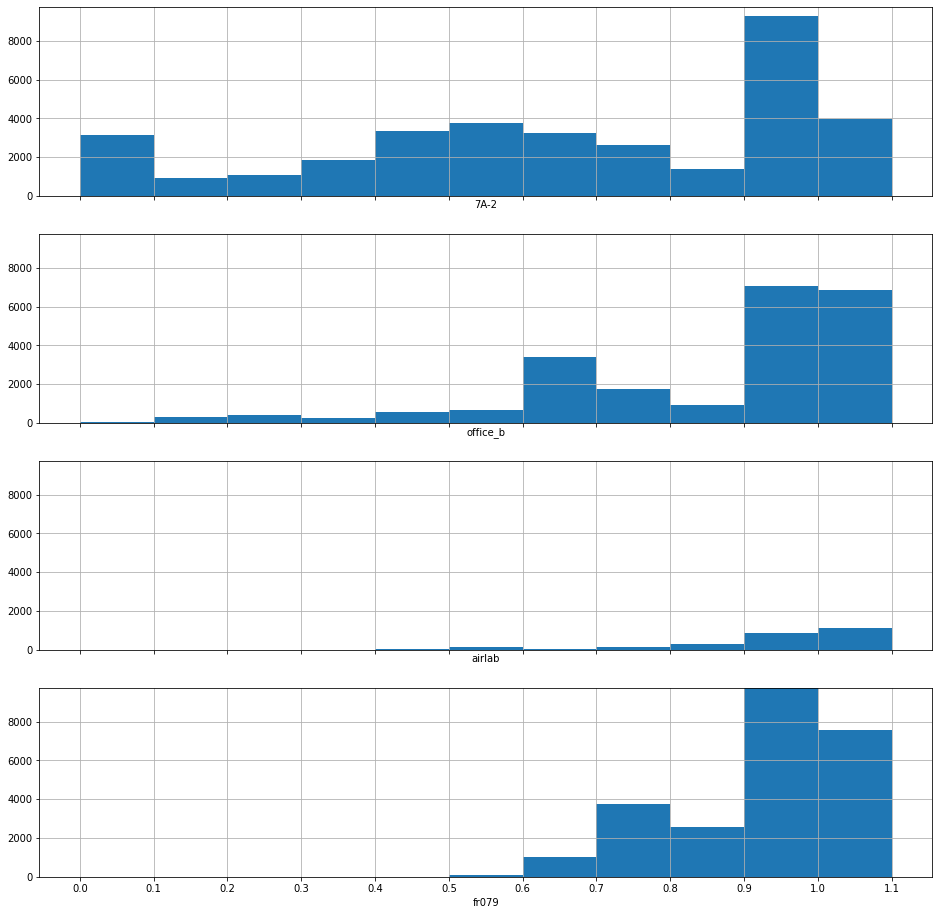

In [51]:
bins = list(np.arange(0.0, 1.2, 0.1))
env_names = df.environment_name.unique()

fig, axs = plt.subplots(len(env_names))
for ax in axs.flat:
    ax.label_outer()

for env_name, ax in zip(env_names, axs):
    df_by_env = df[df.environment_name == env_name]
    ax.hist(df_by_env.lvr, bins=bins)
    ax.set(xlabel=env_name, xticks=bins)
    ax.sharex(axs[0])
    ax.sharey(axs[0])
    ax.grid(True)

fig.set_size_inches([16, 16])
plt.show()

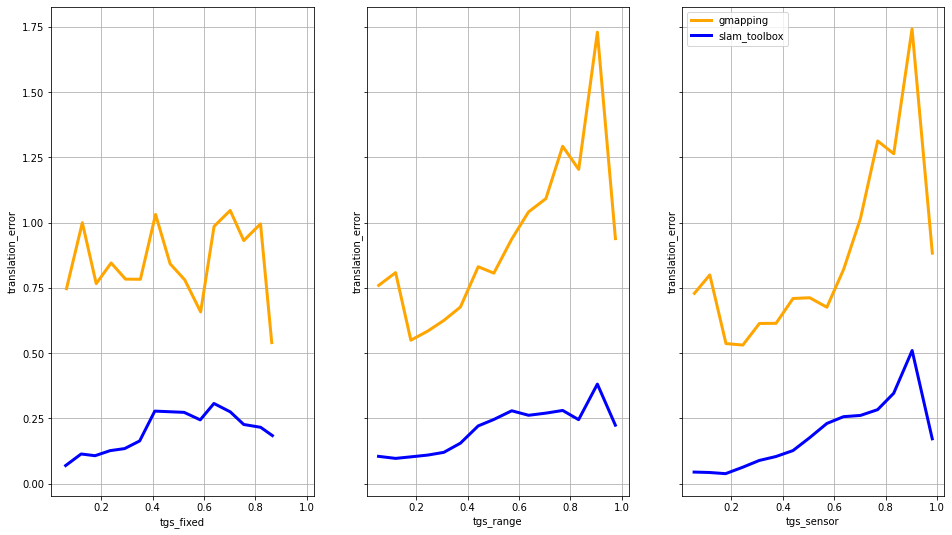

In [52]:
fig, axs = plt.subplots(1, 3)
for ax in axs.flat:
    ax.label_outer()

gs_metrics = [df.tgs_fixed, df.tgs_range, df.tgs_sensor]
for gs_metric, ax in zip(gs_metrics, axs):
    plot_model(
        [
            ModelPlot(gs_metric, df.translation_error, df[df.slam_node == 'gmapping'], 'gmapping', 'orange'), 
            ModelPlot(gs_metric, df.translation_error, df[df.slam_node == 'slam_toolbox'], 'slam_toolbox', 'blue'),
        ],
        n_bins_default,
        ax=ax,
    )
    ax.grid(True)
    ax.sharex(axs[0])
    ax.sharey(axs[0])
plt.legend()
plt.show()

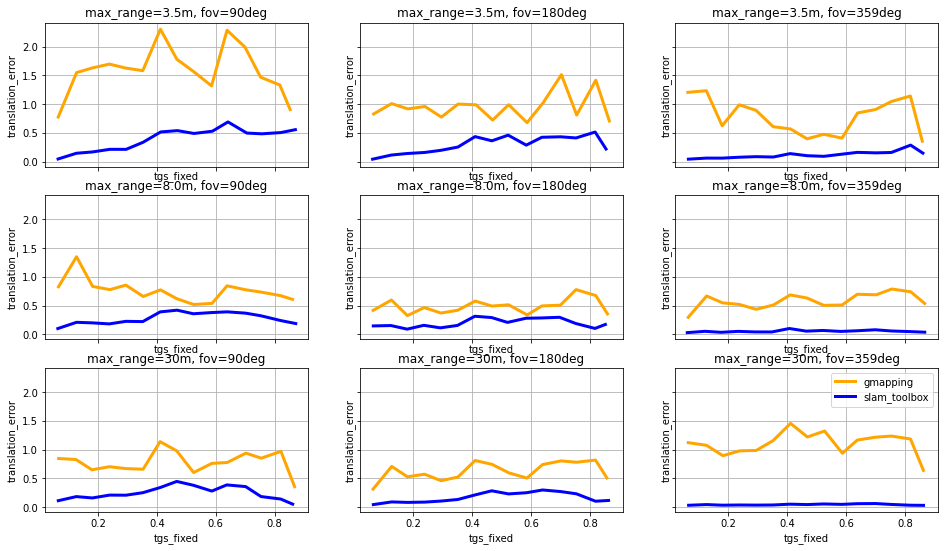

In [53]:
fig, axs = plt.subplots(3, 3)
for ax in axs.flat:
    ax.set(xlabel='translation geometric similarity (fixed range and fov)', ylabel='translation error')
for ax in axs.flat:
    ax.label_outer()

mrs = [3.5, 8.0, 30]
fovs = [90, 180, 359]
for i, mr in enumerate(mrs):
    for j, fov in enumerate(fovs):
        plot_model(
            [
                ModelPlot(
                    df.tgs_fixed,
                    df.translation_error,
                    df[(df.slam_node == 'gmapping') &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov)],
                    'gmapping', 'orange'),
                ModelPlot(
                    df.tgs_fixed,
                    df.translation_error,
                    df[(df.slam_node == 'slam_toolbox') &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov)],
                    'slam_toolbox', 'blue'),
            ], 
            n_bins_default,
            axs[i, j])
        axs[i, j].set_title(f"max_range={mr}m, fov={fov}deg")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)

plt.legend()
plt.show()

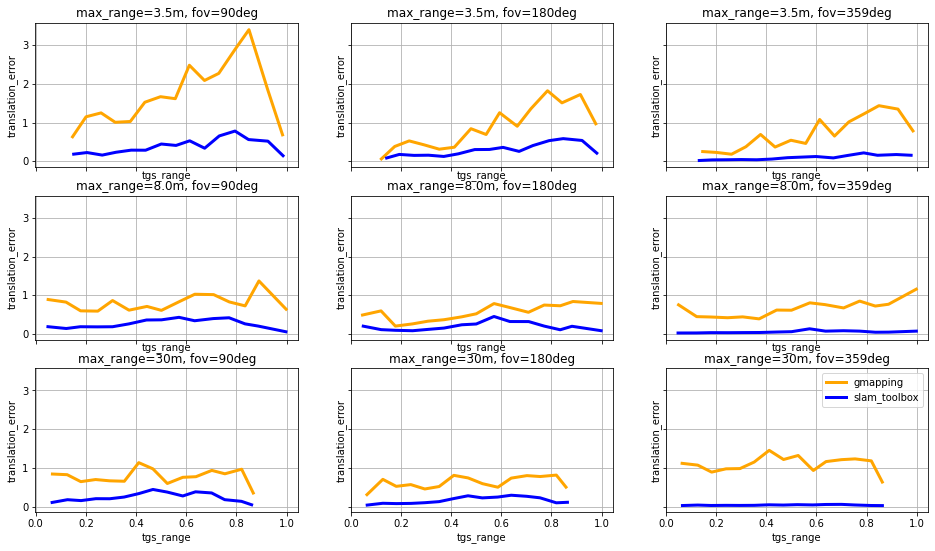

In [54]:
fig, axs = plt.subplots(3, 3)
for ax in axs.flat:
    ax.set(xlabel='translation geometric similarity (fixed range and fov)', ylabel='translation error')
for ax in axs.flat:
    ax.label_outer()

mrs = [3.5, 8.0, 30]
fovs = [90, 180, 359]
for i, mr in enumerate(mrs):
    for j, fov in enumerate(fovs):
        plot_model(
            [
                ModelPlot(
                    df.tgs_range,
                    df.translation_error,
                    df[(df.slam_node == 'gmapping') &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov)],
                    'gmapping', 'orange'),
                ModelPlot(
                    df.tgs_range,
                    df.translation_error,
                    df[(df.slam_node == 'slam_toolbox') &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov)],
                    'slam_toolbox', 'blue'),
            ], 
            n_bins_default,
            axs[i, j])
        axs[i, j].set_title(f"max_range={mr}m, fov={fov}deg")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)

plt.legend()
plt.show()

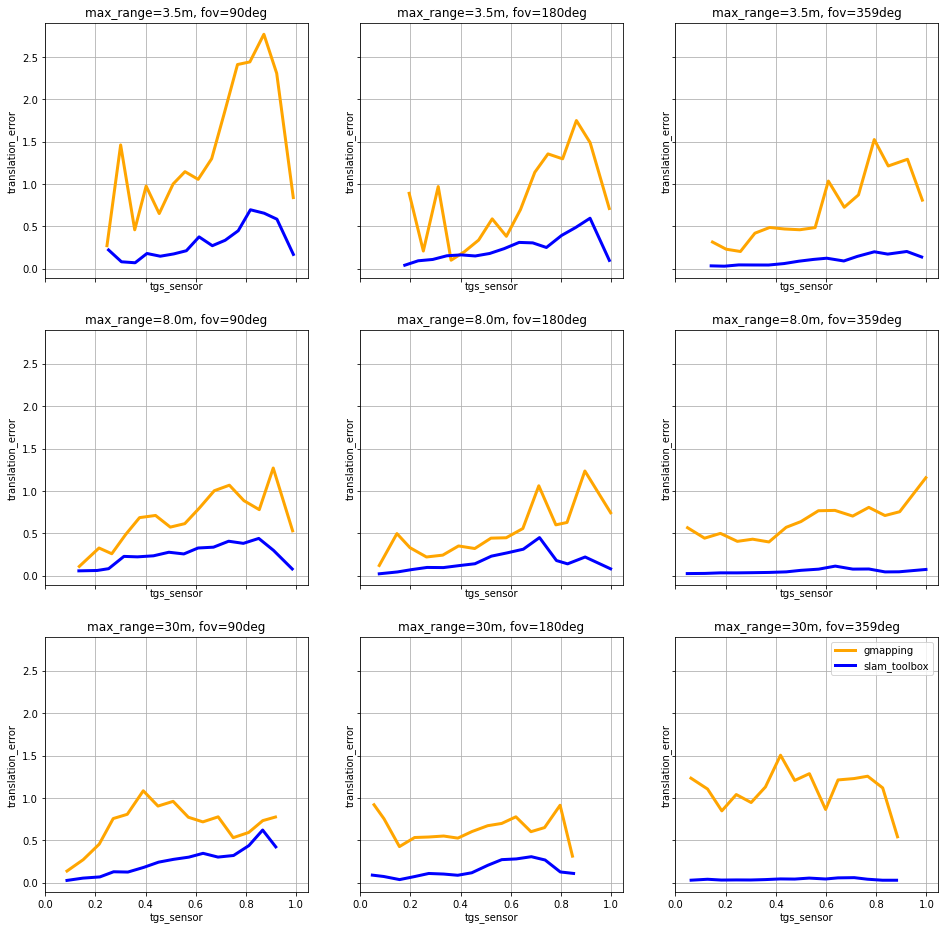

In [55]:
fig, axs = plt.subplots(3, 3)
for ax in axs.flat:
    ax.label_outer()

mrs = [3.5, 8.0, 30]
fovs = [90, 180, 359]
for i, mr in enumerate(mrs):
    for j, fov in enumerate(fovs):
        plot_model(
            [
                ModelPlot(
                    df.tgs_sensor,
                    df.translation_error,
                    df[(df.slam_node == 'gmapping') &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov)],
                    'gmapping', 'orange'),
                ModelPlot(
                    df.tgs_sensor,
                    df.translation_error,
                    df[(df.slam_node == 'slam_toolbox') &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov)],
                    'slam_toolbox', 'blue'),
            ], 
            n_bins_default,
            axs[i, j])
        axs[i, j].set_title(f"max_range={mr}m, fov={fov}deg")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)

fig.set_size_inches([16, 16])
plt.legend()
plt.show()

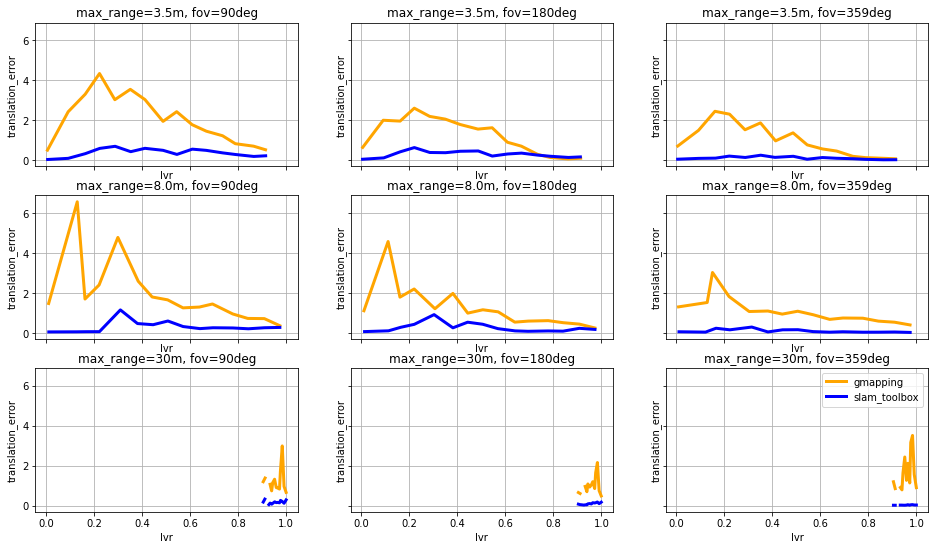

In [56]:
fig, axs = plt.subplots(3, 3)
for ax in axs.flat:
    ax.label_outer()

mrs = [3.5, 8.0, 30]
fovs = [90, 180, 359]
for i, mr in enumerate(mrs):
    for j, fov in enumerate(fovs):
        plot_model(
            [
                ModelPlot(
                    df.lvr,
                    df.translation_error,
                    df[(df.slam_node == 'gmapping') &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov)],
                    'gmapping', 'orange'),
                ModelPlot(
                    df.lvr,
                    df.translation_error,
                    df[(df.slam_node == 'slam_toolbox') &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov)],
                    'slam_toolbox', 'blue'),
            ], 
            n_bins_default,
            axs[i, j])
        axs[i, j].set_title(f"max_range={mr}m, fov={fov}deg")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)

plt.legend()
plt.show()

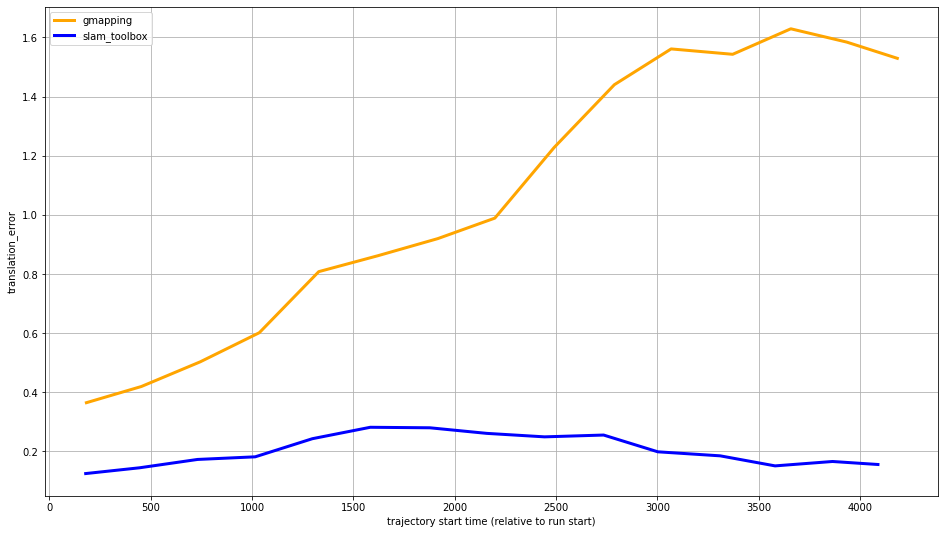

In [57]:
plot_model(
    [
        ModelPlot(
            df.start_time, 
            df.translation_error, 
            df[df.slam_node == 'gmapping'], 
            'gmapping', 'orange'), 
        ModelPlot(
            df.start_time,
            df.translation_error, 
            df[df.slam_node == 'slam_toolbox'], 
            'slam_toolbox', 'blue'),
    ],
    n_bins_default)

plt.legend()
plt.xlabel("trajectory start time (relative to run start)")
plt.grid(True)
plt.show()

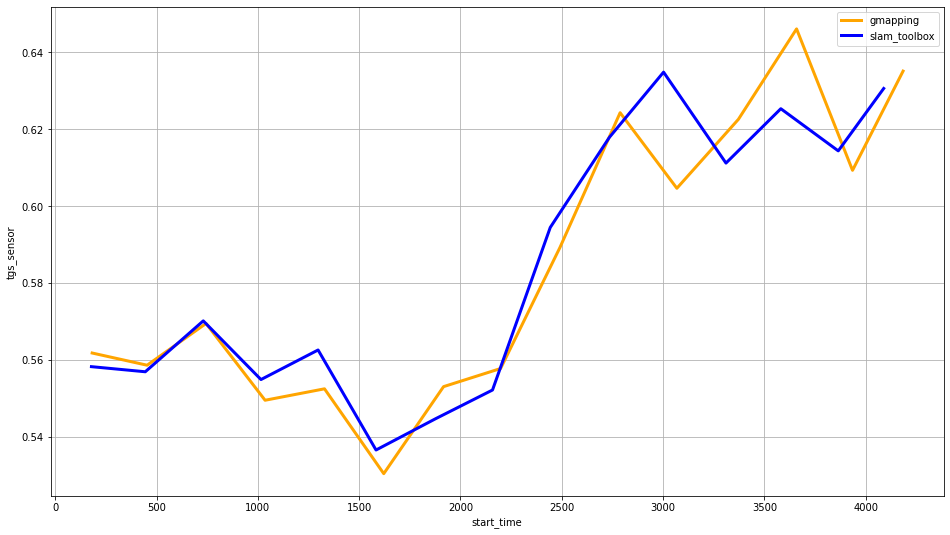

In [58]:
plot_model(
    [
        ModelPlot(
            df.start_time, 
            df.tgs_sensor, 
            df[df.slam_node == 'gmapping'], 
            'gmapping', 'orange'), 
        ModelPlot(
            df.start_time,
            df.tgs_sensor, 
            df[df.slam_node == 'slam_toolbox'], 
            'slam_toolbox', 'blue'),
    ],
    n_bins_default)

plt.legend()
plt.grid(True)
plt.show()